In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['Device:', 'rrqm/s', 'wrqm/s', 'r/s', 'w/s', 'rkB/s', 'wkB/s', 'avgrq-sz', 'avgqu-sz',
                  'await', 'r_await', 'w_await', 'svctm', '%util']
TEST_CONFIG = 'fixed-rate-submit'
DISK_CONFIG = 'hdd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['sdb', 'sdc', 'sdd', 'sde', 'sdf', 'sdg', 'sdh', 'sdi']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat_ns.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%util', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%util', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# ZFS on Linux #6566 Performance Results - Fixed Rate Submit on HDDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would attempt to acheive a bandwidth of about 64 writes per second; i.e. after a write completes, the thread may artficially delay, such that it doesn't exceed its target of 64 write operations per second. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

# Real world random request flow follows Poisson process. To give better
# insight on latency distribution, we simulate request flow under Poisson
# process.
rate_process=poisson
rate_iops=64

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 8 vCPUs
 - 128 GB of RAM
 - Traditional Magnetic Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

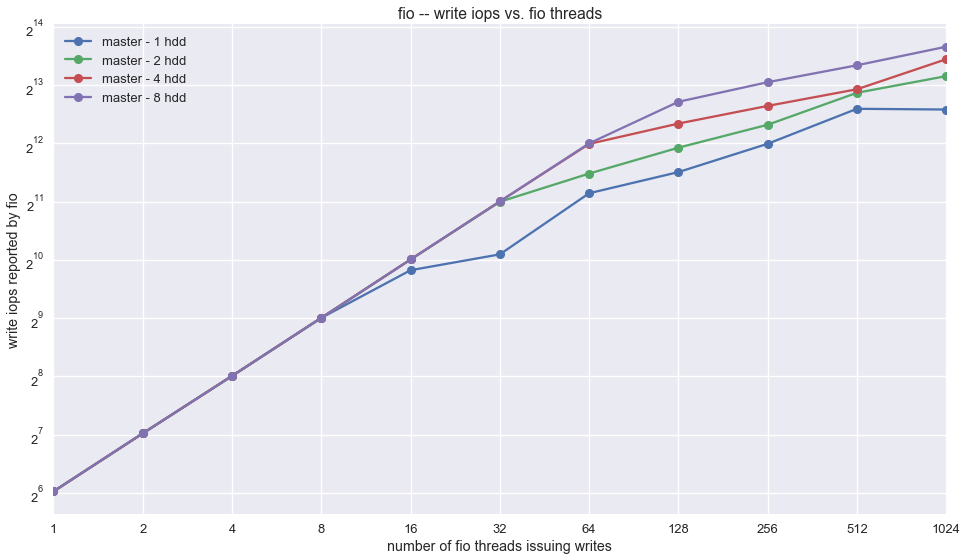

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,65.093586,65.105511,65.095754,65.102258
2,129.910573,129.914900,129.923555,129.932211
4,257.319876,257.289880,257.311305,257.315590
8,513.665662,513.755662,513.772774,513.713344
16,905.550649,1028.690367,1028.775541,1028.694667
32,1093.448764,2044.559240,2052.638591,2052.740262
64,2262.814213,2859.835355,4069.510163,4095.288063
128,2910.368951,3891.265597,5185.230851,6717.856429
256,4076.732179,5112.197315,6397.904800,8481.371634
512,6180.852658,7476.993788,7797.634101,10372.674428


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

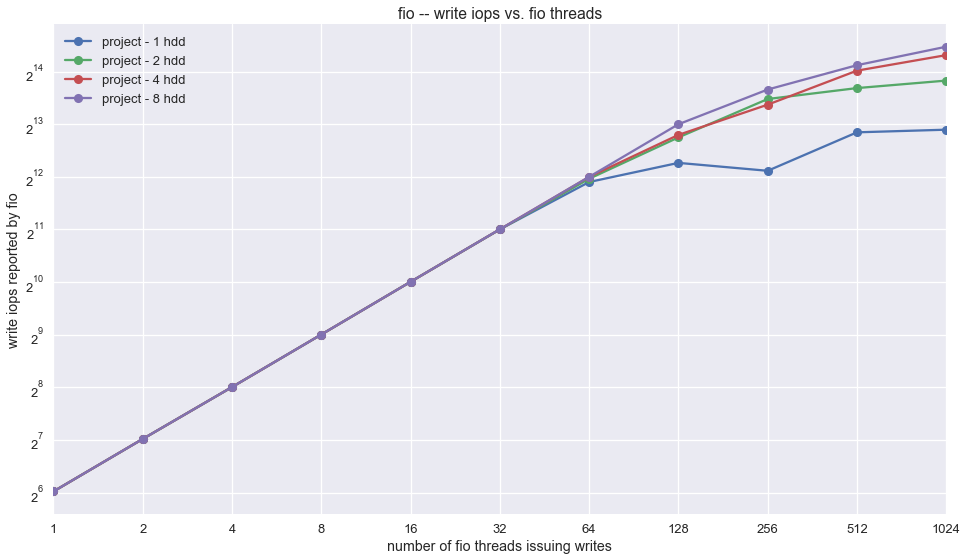

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,65.093586,65.095754,65.102258,65.105511
2,129.910573,129.927883,129.925719,129.930047
4,257.311305,257.311305,257.315590,257.311305
8,513.670574,513.730911,513.781331,513.797985
16,1028.579042,1028.607587,1028.535753,1028.590459
32,2051.464832,2050.174971,2052.705201,2052.890140
64,3825.866005,3993.002216,4091.953449,4095.800110
128,4922.703946,6881.576755,7115.333989,8185.533020
256,4435.601013,11411.265869,10594.508131,12927.019823
512,7359.768308,13177.354342,16576.668110,17811.450839


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

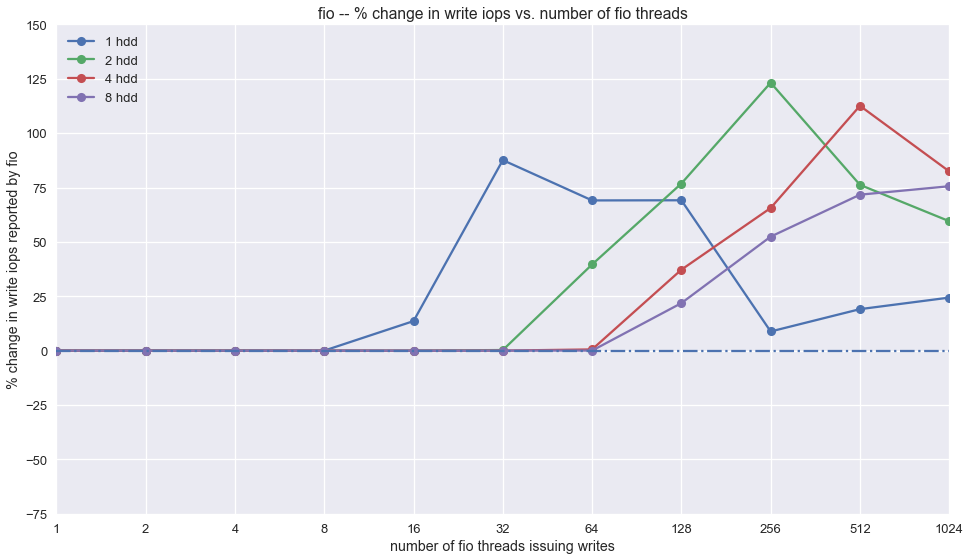

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-75, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 hdd,2 hdd,4 hdd,8 hdd
1,0.000000,-0.014986,0.009991,0.004997
2,0.000000,0.009993,0.001666,-0.001665
4,-0.003331,0.008327,0.001665,-0.001665
8,0.000956,-0.004818,0.001666,0.016476
16,13.586031,-0.008047,-0.023308,-0.010130
32,87.614171,0.274667,0.003245,0.007301
64,69.075569,39.623500,0.551498,0.012503
128,69.143639,76.846750,37.223090,21.847394
256,8.802855,123.216460,65.593401,52.416618
512,19.073673,76.238669,112.585868,71.715125


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

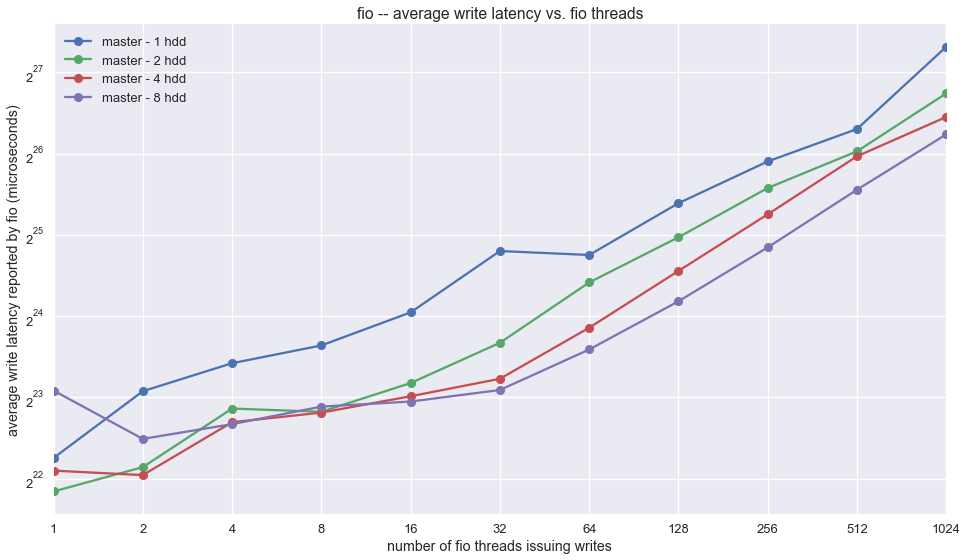

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,5.007139e+06,3.764597e+06,4.496550e+06,8.897619e+06
2,8.849717e+06,4.632916e+06,4.328195e+06,5.894360e+06
4,1.123653e+07,7.633209e+06,6.794395e+06,6.683377e+06
8,1.307455e+07,7.425549e+06,7.374343e+06,7.760204e+06
16,1.733139e+07,9.487464e+06,8.477484e+06,8.104603e+06
32,2.924265e+07,1.337334e+07,9.838260e+06,8.941769e+06
64,2.827103e+07,2.237252e+07,1.520609e+07,1.263150e+07
128,4.397275e+07,3.288448e+07,2.468116e+07,1.905012e+07
256,6.277109e+07,5.006170e+07,3.999879e+07,3.017495e+07
512,8.276952e+07,6.842944e+07,6.559991e+07,4.933149e+07


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

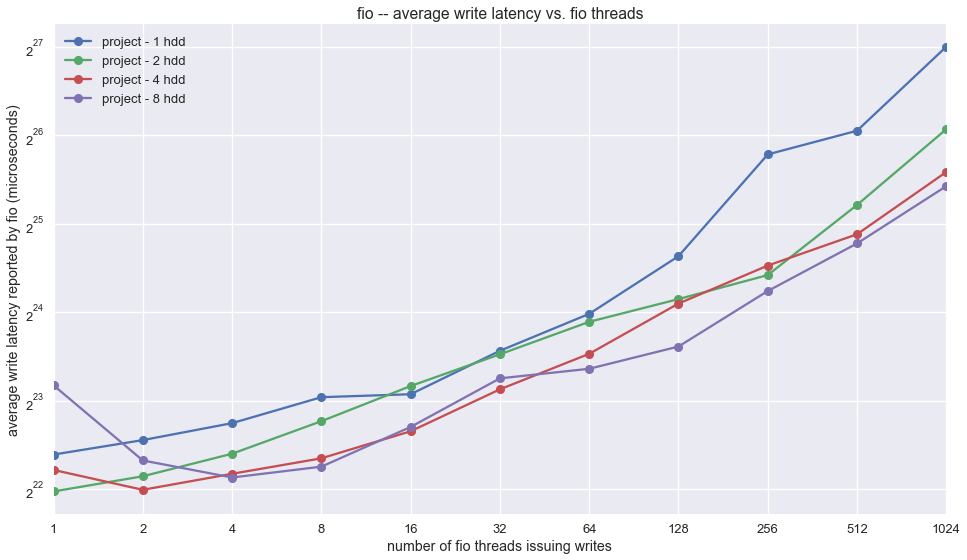

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,5.495574e+06,4.116302e+06,4.872636e+06,9.454623e+06
2,6.155186e+06,4.636622e+06,4.170070e+06,5.248246e+06
4,7.029077e+06,5.531543e+06,4.727076e+06,4.591848e+06
8,8.614703e+06,7.137553e+06,5.336879e+06,4.999104e+06
16,8.816228e+06,9.399876e+06,6.596411e+06,6.822863e+06
32,1.239085e+07,1.205461e+07,9.162188e+06,9.984541e+06
64,1.654979e+07,1.554604e+07,1.210105e+07,1.076243e+07
128,2.599536e+07,1.857650e+07,1.793607e+07,1.281049e+07
256,5.769646e+07,2.242613e+07,2.415520e+07,1.979124e+07
512,6.946466e+07,3.883391e+07,3.087068e+07,2.872802e+07


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

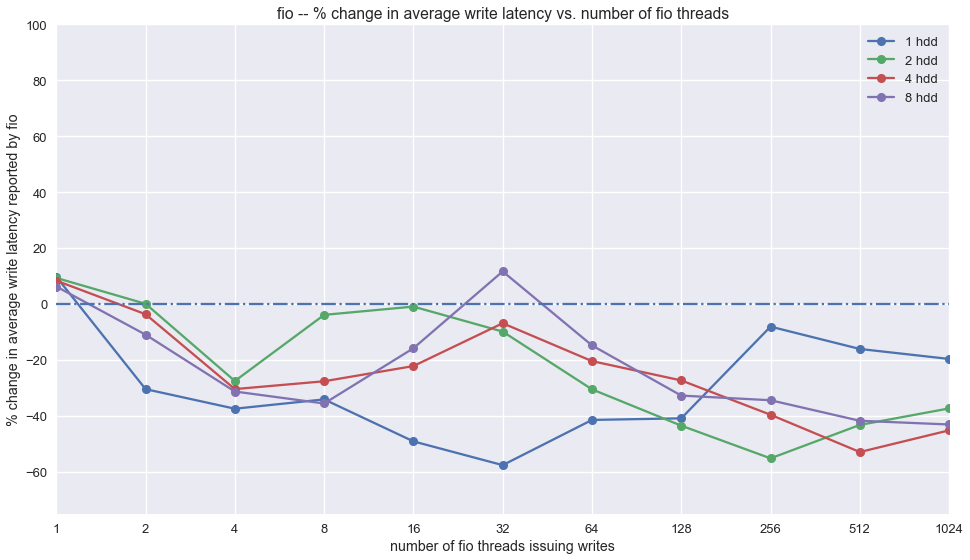

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-75, 100)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 hdd,2 hdd,4 hdd,8 hdd
1,9.754759,9.342438,8.363868,6.260146
2,-30.447656,0.079995,-3.653359,-10.961565
4,-37.444417,-27.533191,-30.426833,-31.294492
8,-34.110889,-3.878443,-27.629099,-35.580254
16,-49.131451,-0.923200,-22.189051,-15.814964
32,-57.627466,-9.860883,-6.871863,11.661809
64,-41.460238,-30.512781,-20.419725,-14.796846
128,-40.883017,-43.509836,-27.328876,-32.753741
256,-8.084345,-55.203009,-39.610187,-34.411678
512,-16.074588,-43.249694,-52.940973,-41.765356


## `%util` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%util` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -x 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%util` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%util` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%util` averaged across all disks in zpool vs. `fio` threads - master branch

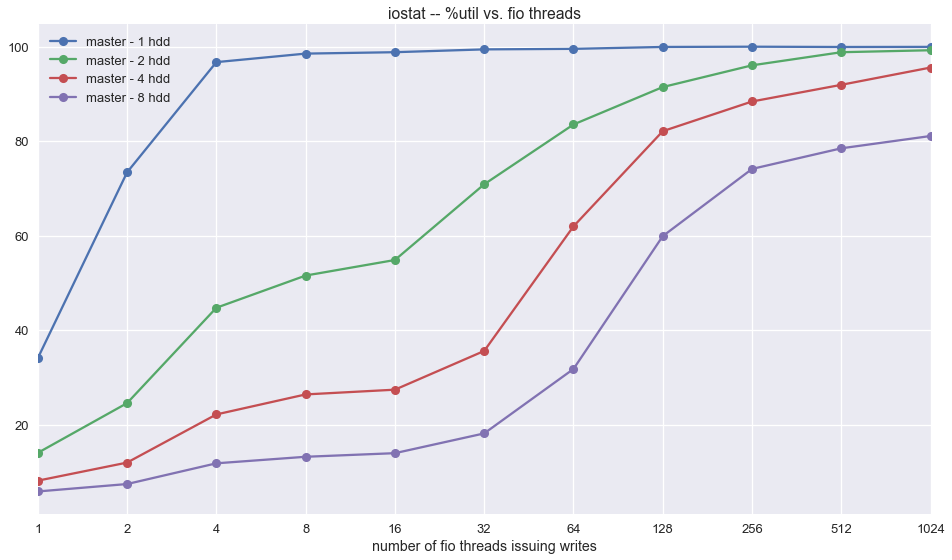

In [15]:
plot_iostat_column_dataframe(master_busy, '%util')

In [16]:
master_busy

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,34.074727,14.043636,8.160000,5.876364
2,73.396364,24.567273,11.985455,7.447273
4,96.712727,44.741818,22.174545,11.832727
8,98.516364,51.556364,26.407273,13.214545
16,98.814545,54.850909,27.410909,13.978182
32,99.410909,70.865455,35.607273,18.160000
64,99.520000,83.520000,61.963636,31.789091
128,99.923818,91.438182,82.101818,59.898182
256,99.978182,96.036364,88.384909,74.116364
512,99.916545,98.811818,91.912727,78.480000


### `%util` averaged across all disks in zpool vs. `fio` threads - project branch

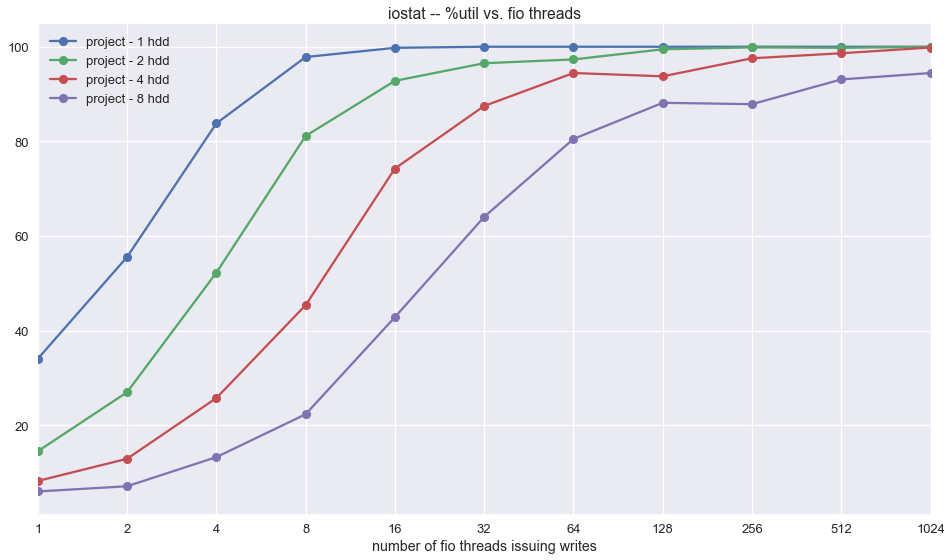

In [17]:
plot_iostat_column_dataframe(project_busy, '%util')

In [18]:
project_busy

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,34.087273,14.552727,8.283636,6.064364
2,55.582727,27.032727,12.967273,7.163636
4,83.803636,52.269091,25.789091,13.316364
8,97.818182,81.149091,45.418182,22.370909
16,99.760000,92.792727,74.269091,42.881091
32,99.992727,96.509091,87.483636,64.065455
64,99.992727,97.309091,94.443636,80.516364
128,99.985455,99.454545,93.745455,88.150727
256,100.000000,99.854545,97.553273,87.861636
512,99.989464,99.763818,98.616182,93.089818
